In [1]:
!pip install -U transformers datasets accelerate scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 12.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [2]:
import torch
print("GPU available:", torch.cuda.is_available())


GPU available: True


In [3]:
from datasets import load_dataset

dataset = load_dataset("imdb")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
train_data = dataset["train"].shuffle(seed=42).select(range(12000))
test_data  = dataset["test"].shuffle(seed=42).select(range(2000))


In [5]:
print(len(train_data), len(test_data))


12000 2000


In [6]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
print(model.config.num_labels)


2


In [8]:
def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )


In [9]:
train_tokenized = train_data.map(tokenize, batched=True)
test_tokenized  = test_data.map(tokenize, batched=True)


Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [10]:
train_tokenized = train_data.map(tokenize, batched=True)
test_tokenized  = test_data.map(tokenize, batched=True)


In [11]:
train_tokenized.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

test_tokenized.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)


In [12]:
print(train_tokenized[0].keys())


dict_keys(['label', 'input_ids', 'attention_mask'])


In [13]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="no",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=200,
    report_to="none"
)


In [14]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized
)


In [15]:
trainer.train()


Epoch,Training Loss,Validation Loss
1,0.304600,0.229092
2,0.215400,0.276170
3,0.140000,0.352575


TrainOutput(global_step=2250, training_loss=0.24594617165459526, metrics={'train_runtime': 856.7492, 'train_samples_per_second': 42.019, 'train_steps_per_second': 2.626, 'total_flos': 2367999498240000.0, 'train_loss': 0.24594617165459526, 'epoch': 3.0})

In [16]:
trainer.save_model("./roberta_sentiment_model")
tokenizer.save_pretrained("./roberta_sentiment_model")


('./roberta_sentiment_model/tokenizer_config.json',
 './roberta_sentiment_model/special_tokens_map.json',
 './roberta_sentiment_model/vocab.json',
 './roberta_sentiment_model/merges.txt',
 './roberta_sentiment_model/added_tokens.json')

In [17]:
import numpy as np
from sklearn.metrics import accuracy_score

predictions = trainer.predict(test_tokenized)

y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

accuracy = accuracy_score(y_true, y_pred)
print("RoBERTa Accuracy:", accuracy)


RoBERTa Accuracy: 0.9135


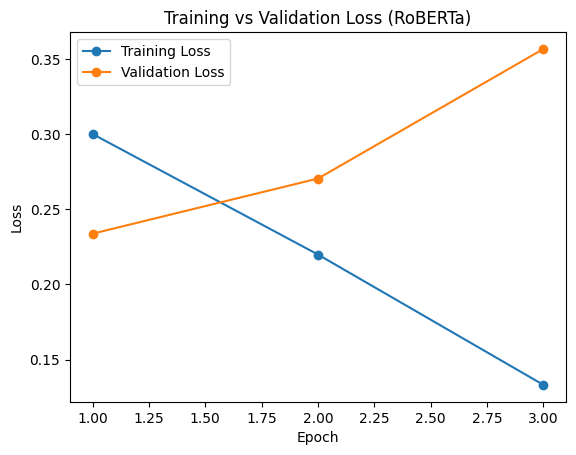

In [6]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3]
training_loss = [0.3000, 0.2198, 0.1331]
validation_loss = [0.2337, 0.2704, 0.3566]

plt.figure()
plt.plot(epochs, training_loss, marker='o', label='Training Loss')
plt.plot(epochs, validation_loss, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (RoBERTa)')
plt.legend()
plt.show()
